# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import sys
sys.setrecursionlimit(2000)

if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate



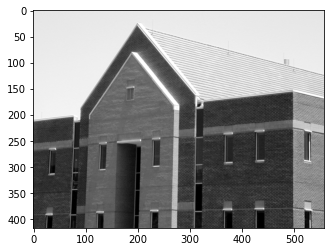

In [2]:
#1
house = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(house, 'gray')
plt.show()

Text(0.5, 1.0, 'Difference')

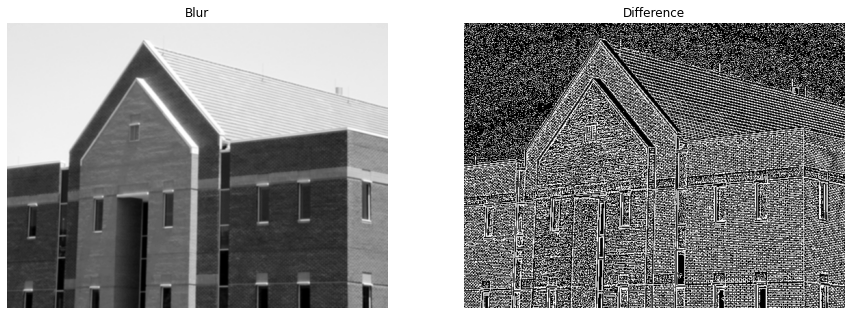

In [3]:
#2
houseBlur = cv2.GaussianBlur(house, (3,3), 0.9)
[f, ax] = plt.subplots(1,2)
f.set_size_inches(15,7)
ax[0].imshow(houseBlur, 'gray', vmin=0, vmax=256)
ax[0].axis('off')
ax[0].set_title("Blur")
ax[1].imshow(np.abs(house-houseBlur),'gray')
ax[1].axis('off')
ax[1].set_title("Difference")

In [4]:
LoG = cv2.Laplacian(houseBlur, cv2.CV_32F)

In [5]:
def crossing(LoG, thr, kSize):

    res = LoG.copy()
    
    x,y = LoG.shape
    
    for i in range(1, x-1):
        for j in range(1, y-1):
            ctx = LoG[i-1:i+2,j-1:j+2]
            ctxMin = np.min(ctx)
            ctxMax = np.max(ctx)
            if ctxMin * ctxMax < 0:
                if LoG[i][j] > 0:
                    res[i][j] = LoG[i][j] + np.abs(ctxMin)
                else:
                    res[i][j] = np.abs(LoG[i][j]) + ctxMax
    res = (res/np.max(res)) * 255
    res2 = ((res > thr) * 255).astype('uint8')
    return cv2.medianBlur(res2, kSize)

Text(0.5, 1.0, 'thr = 85')

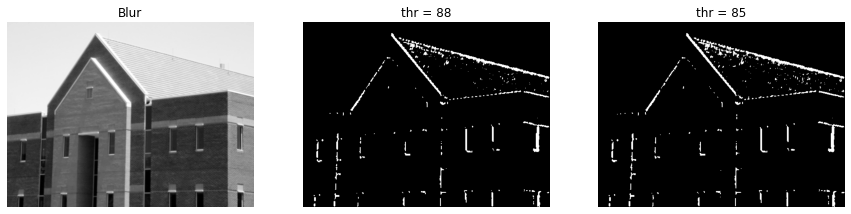

In [6]:
cr = crossing(LoG, 88,3)
cr2 = crossing(LoG, 85,3)


[f, ax] = plt.subplots(1,3)
f.set_size_inches(15,7)
ax[0].imshow(houseBlur, 'gray', vmin=0, vmax=256)
ax[0].axis('off')
ax[0].set_title("Blur")
ax[1].imshow(cr,'gray')
ax[1].axis('off')
ax[1].set_title("thr = 88")
ax[2].imshow(cr2,'gray')
ax[2].axis('off')
ax[2].set_title("thr = 85")

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w~1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj pierwszą część algorytmu detekcji krawędzi Canny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
7. Na jednym obrazie zaznacz piksele należące do obrazu $g_{NH}$ jako czerwone oraz należące do obrazu $g_{NL}$ jako niebieskie.
Wyświetl obraz.

In [7]:
def nonmax(dirs, M):
    direction = dirs[1,1]
    (x,y) = dirs.shape
    for i in range(x):
        for j in range(y):
            if dirs[i,j] == direction and M[i,j] > M[1,1]:
                return 0
    return M[1,1]

def canny(I, kSize, std, thrHigh, thrLow):
    x, y = I.shape
    Iblur = cv2.GaussianBlur(I, (kSize, kSize), std)
    
    SobelX = cv2.Sobel(Iblur, cv2.CV_64F, 1, 0, ksize=kSize)
    SobelY = cv2.Sobel(Iblur, cv2.CV_64F, 0, 1, ksize=kSize)
    
    M = np.sqrt(SobelX**2 + SobelY**2)
    alpha = np.arctan2(SobelY, SobelX)
    
    res = np.zeros((x,y))
    for i in range(1, x-1):
        for j in range(1, y-1):
            ctx_dirs = alpha[i-1 : i+2, j-1 : j+2]
            ctx_M = M[i-1 : i+2, j-1 : j+2]
            
            x1,y1 = ctx_dirs.shape
            q_res = np.zeros((x1,y1))
            for ii in range(x1):
                for jj in range(y1):
                    if (ctx_dirs[ii,jj] <= np.pi/8 and ctx_dirs[ii,jj] >= -np.pi/8) or (ctx_dirs[ii,jj] <= np.pi + np.pi/8 and ctx_dirs[ii,jj] >= np.pi - np.pi/8):
                        q_res[ii,jj] = 1
                        
                    elif (ctx_dirs[ii,jj] <= np.pi/2 + np.pi/8 and ctx_dirs[ii,jj] >= np.pi/2 - np.pi/8) or (ctx_dirs[ii,jj] <= 3*np.pi/2 + np.pi/8 and ctx_dirs[ii,jj] >= 3*np.pi/2 - np.pi/8):
                        q_res[ii,jj] = 2
                        
                    elif (ctx_dirs[ii,jj] <= np.pi/4 + np.pi/8 and ctx_dirs[ii,jj] >= np.pi/4 - np.pi/8) or (ctx_dirs[ii,jj] <= 5*np.pi/4 + np.pi/8 and ctx_dirs[ii,jj] >= 5*np.pi/4 - np.pi/8):
                        q_res[ii,jj] = 3
                        
                    else:
                        q_res[ii,jj] = 4
            res[i,j] = nonmax(q_res, ctx_M)
    gnh = res >= thrHigh
    gnl = (thrHigh > res)*(res >= thrLow)

    #rgb
    Ires = np.zeros((x,y,3))
    Ires[:,:,0] = gnh * 255
    Ires[:,:,2] = gnl * 255
    return Ires

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Canny gray')

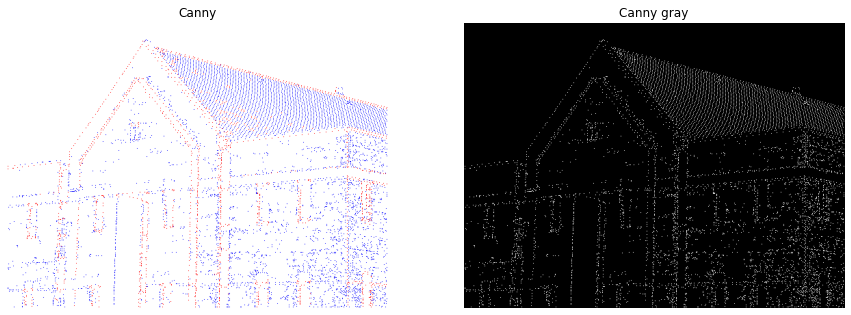

In [8]:
houseCanny = canny(house, 3, 0.8, 150, 50)


houseCanny2=  houseCanny.copy()
for i in range(houseCanny2.shape[0]):
    for j in range(houseCanny2.shape[1]):
        if houseCanny2[i,j,0] == 0 and houseCanny2[i,j,2] == 0:
            houseCanny2[i,j] = [255,255,255]

[f, ax] = plt.subplots(1,2)
f.set_size_inches(15,7)
ax[0].imshow(houseCanny2,'gray')
ax[0].axis('off')
ax[0].set_title("Canny")
ax[1].imshow((houseCanny[:,:,0] + houseCanny[:,:,2])>0, 'gray')
ax[1].axis('off')
ax[1].set_title("Canny gray")

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z wykonaną częściową implementacją w poprzednim ćwiczeniu.
Na czym polegają różnice?

Text(0.5, 1.0, 'Canny - openCV')

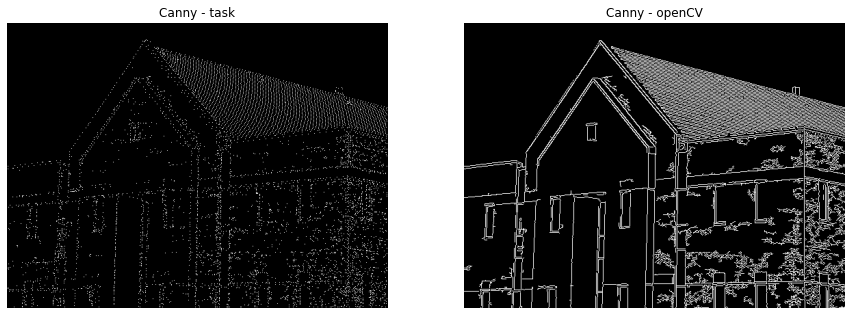

In [9]:
IcannyCV = cv2.Canny(house, 50, 150, None, 3, 1)

[f, ax] = plt.subplots(1,2)
f.set_size_inches(15,7)
ax[0].imshow((houseCanny[:,:,0] + houseCanny[:,:,2])>0, 'gray')
ax[0].axis('off')
ax[0].set_title("Canny - task")
ax[1].imshow(IcannyCV,'gray')
ax[1].axis('off')
ax[1].set_title("Canny - openCV")